In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import namedtuple

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [4]:
np.set_printoptions(linewidth=160)
# Avoid escaping any latex characters
tabulate.LATEX_ESCAPE_RULES = {}

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

QUERY_ORDINAL_POSITION_COMORLAP= 'cool'
NUM_TIMES_TRAINED_COLORMAP = 'copper'

In [5]:
cache = analysis.refresh_cache()
print(cache.keys())

six_replications_analyses = cache['six_replications_analyses']
# query_mod_replications = cache['query_mod_replications']
control_analyses = cache['control_analyses']
six_replications_updated_analyses = cache['six_replications_updated_analyses']
control_updated_analyses = cache['updated_control_analyses']
query_mod_updated_analyses = cache['query_mod_updated_analyses']
task_conditional_analyses = cache['task_conditional_analyses']
task_conditional_multiplicative_only_analyses = cache['task_conditional_multiplicative_only_analyses']
task_conditional_additive_only_analyses = cache['task_conditional_additive_only_analyses']

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data', 'preliminary_maml_analyses', 'baseline_maml_comparison_analyses', 'maml_analyses', 'maml_alpha_0_analyses', 'maml_meta_test_analyses', 'balanced_batches_analyses', 'baseline_total_curve_analyses', 'control_total_curve_analyses', 'query_mod_total_curve_analyses', 'simultaneous_training_analyses', 'per_task_simultaneous_training_analyses', 'task_conditional_analyses', 'task_conditional_multiplicative_only_analyses', 'task_conditional_additive_only_analyses'])


-------

# Plotting the new data

Task-conditional (or TC) is the new approach, plotted either with both additive and multiplicative modulation or only one of them.

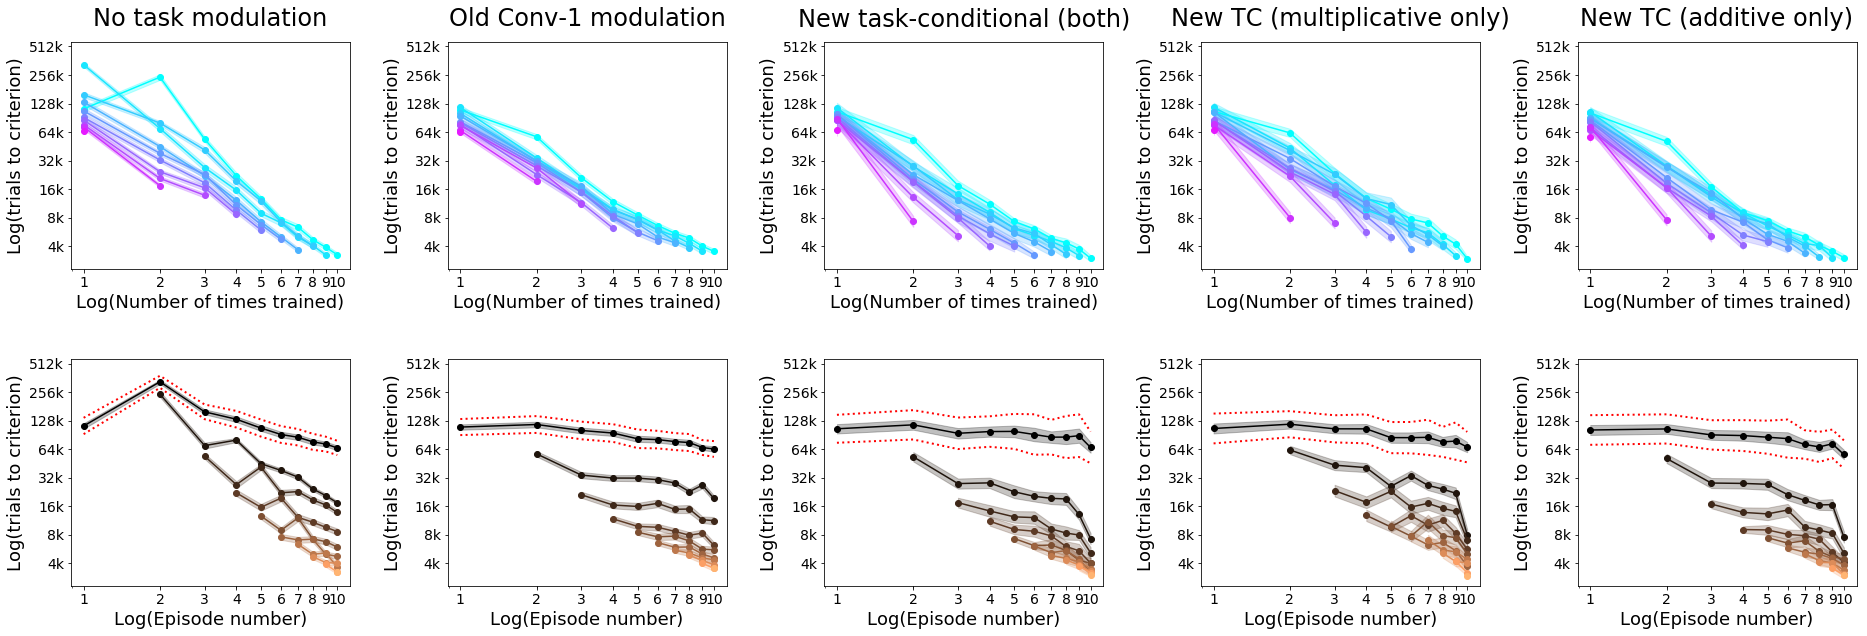

In [6]:
NROWS = 2
NCOLS = 5
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)

LOG_PLOT_YLIM = (7.75, 13.25)

axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(six_replications_analyses, data_index=1, 
                                            title='',
                                            ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=(60, 60, 60, 180), shade_error=True,
                                            font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(3,),
                                            num_tasks_trained_highlight_first_time='highlight', add_colorbars=False,
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            num_times_trained_title='No task modulation',
#                                             plot_regression=True, regression_legend=True
                                           )

mod_level = 1
axes = (plt.subplot(NROWS, NCOLS, 1 + mod_level), plt.subplot(NROWS, NCOLS, NCOLS + 1 + mod_level))
plots.plot_processed_results_all_dimensions(query_mod_updated_analyses[mod_level], data_index=1, 
                                            title='',
                                            ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=(60, 60, 60, 180), shade_error=True,
                                            font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(3,),
                                            num_tasks_trained_highlight_first_time='highlight', add_colorbars=False,
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            num_times_trained_title=f'Old Conv-{mod_level} modulation',
#                                             plot_regression=True, regression_legend=True
                                           )

for i, (data, name) in enumerate(
    zip( (task_conditional_analyses, task_conditional_multiplicative_only_analyses, task_conditional_additive_only_analyses),
        ('New task-conditional (both)', 'New TC (multiplicative only)', 'New TC (additive only)'))):
    ax_index = 3 + i
    axes = (plt.subplot(NROWS, NCOLS, ax_index), plt.subplot(NROWS, NCOLS, NCOLS + ax_index))
    plots.plot_processed_results_all_dimensions(data, data_index=1, 
                                                title='',
                                                ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=(20, 20, 20, 60), shade_error=True,
                                                font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                                    dimension_names=('',), dimension_indices=(3,),
                                                num_tasks_trained_highlight_first_time='highlight', add_colorbars=False,
                                                title_font_dict=title_font_dict, external_axes=axes,
                                                num_times_trained_title=name,
#                                                 plot_regression=True, regression_legend=True
                                               )



# plots.save('workshop/combined_by_modulation_level_with_regression.pdf')
plt.show()

------

# Comparison plot, a-la Figure 6 in the paper

Subtracting the results of each task modulation from the results without any modulation. As in the paper, points above the y-axis are ones where task modulation does better, and points below the y-axis are points where the "naive" model does better.

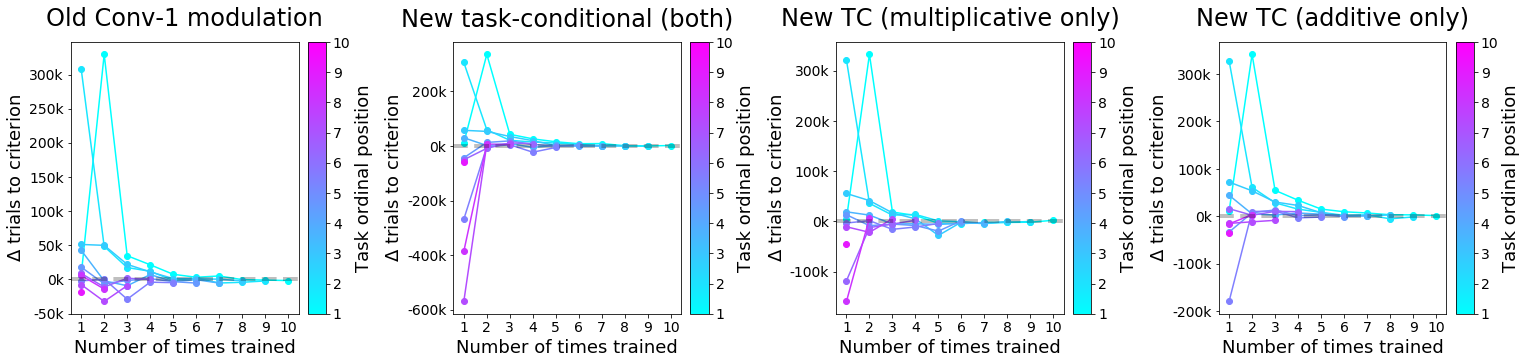

In [39]:
NROWS = 1
NCOLS = 5
COL_WIDTH = 6
ROW_HEIGHT = 5
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.5)


y_tick_formatter = matplotlib.ticker.FuncFormatter(lambda x, pos: f'{int(x // 1000)}k')


comparison_axes = (plt.subplot(NROWS, NCOLS, 1), None)
mod_level = 1
plots.combined_comparison_plots(six_replications_updated_analyses, query_mod_updated_analyses, '',
                                comparison_func=np.subtract,
                                font_dict=multi_plot_font_dict, baseline_first=True, 
                                data_index=0, # ylim=EXAMPLE_RATIO_YLIM, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=title_font_dict,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='$\Delta$ trials to criterion',
#                                 y_custom_tick_labels=[None, '-50k', '0'] + [f'{i * 50}k' for i in range(1, 7)],
                                y_custom_tick_formatter=y_tick_formatter,
                                external_axes=comparison_axes, 
                                replication_levels=(mod_level,), custom_titles=(f'Old Conv-{mod_level} modulation',))



for i, (data, name) in enumerate(
    zip( (task_conditional_analyses, task_conditional_multiplicative_only_analyses, task_conditional_additive_only_analyses),
        ('New task-conditional (both)', 'New TC (multiplicative only)', 'New TC (additive only)'))):
    ax_index = 2 + i
    axes = (plt.subplot(NROWS, NCOLS, ax_index), None)
    plots.combined_comparison_plots(six_replications_updated_analyses, {1: data}, '',
                                comparison_func=np.subtract,
                                font_dict=multi_plot_font_dict, baseline_first=True, 
                                data_index=0, # ylim=EXAMPLE_RATIO_YLIM, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=title_font_dict,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='$\Delta$ trials to criterion',
#                                 y_custom_tick_labels=[None, '-50k', '0'] + [f'{i * 50}k' for i in range(1, 7)],
                                y_custom_tick_formatter=y_tick_formatter,
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(name,))


# TEXT_POSITIONS = [(0.045, 0.825), (0.485, 0.825)]

# subfigure_text_font_dict = FONT_DICT.copy()
# subfigure_text_font_dict['fontsize'] += 4
# subfigure_text_font_dict['color'] = '#808080'
# subfigure_text_font_dict['weight'] = 'bold'

# num_subfigures = len(TEXT_POSITIONS)
# for i in range(num_subfigures):
#     pos = TEXT_POSITIONS[i]
#     plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
#              subfigure_text_font_dict, transform=figure.transFigure)

# # add markings for which plot is which
# cmap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)
# current_font_dict = FONT_DICT.copy()
# current_font_dict['fontsize'] -= 4
# current_font_dict['color'] = matplotlib.colors.to_hex(cmap(0 / 10))
# plt.text(0.615, 0.780, f'1', current_font_dict, transform=figure.transFigure)
# current_font_dict['color'] = matplotlib.colors.to_hex(cmap(1 / 10))
# plt.text(0.5725, 0.825, f'2', current_font_dict, transform=figure.transFigure)

plt.show()

-------

# Comparison to old task modulation

Subtracting the results of the new task-conditional (TC) from the results of the old task modulation (at conv-1). Points above the y-axis are ones where the new task conditional does better, and points below the y-axis are points where the old task modulation  model does better.

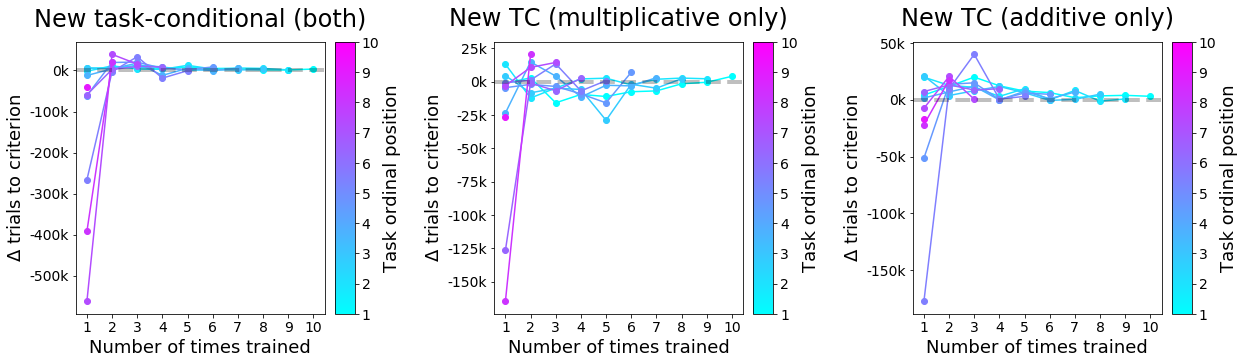

In [40]:
NROWS = 1
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.5)


y_tick_formatter = matplotlib.ticker.FuncFormatter(lambda x, pos: f'{int(x // 1000)}k')

baseline_mod_level = 0
mod_level = 1

for i, (data, name) in enumerate(
    zip( (task_conditional_analyses, task_conditional_multiplicative_only_analyses, task_conditional_additive_only_analyses),
        ('New task-conditional (both)', 'New TC (multiplicative only)', 'New TC (additive only)'))):
    ax_index = 1 + i
    axes = (plt.subplot(NROWS, NCOLS, ax_index), None)
    plots.combined_comparison_plots(query_mod_updated_analyses[mod_level], {1: data}, '',
                                comparison_func=np.subtract,
                                font_dict=multi_plot_font_dict, baseline_first=True, 
                                data_index=0, # ylim=EXAMPLE_RATIO_YLIM, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=title_font_dict,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='$\Delta$ trials to criterion',
                                y_custom_tick_formatter=y_tick_formatter,
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(name,))

    
# TEXT_POSITIONS = [(0.045, 0.825), (0.485, 0.825)]

# subfigure_text_font_dict = FONT_DICT.copy()
# subfigure_text_font_dict['fontsize'] += 4
# subfigure_text_font_dict['color'] = '#808080'
# subfigure_text_font_dict['weight'] = 'bold'

# num_subfigures = len(TEXT_POSITIONS)
# for i in range(num_subfigures):
#     pos = TEXT_POSITIONS[i]
#     plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
#              subfigure_text_font_dict, transform=figure.transFigure)

# # add markings for which plot is which
# cmap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)
# current_font_dict = FONT_DICT.copy()
# current_font_dict['fontsize'] -= 4
# current_font_dict['color'] = matplotlib.colors.to_hex(cmap(0 / 10))
# plt.text(0.615, 0.780, f'1', current_font_dict, transform=figure.transFigure)
# current_font_dict['color'] = matplotlib.colors.to_hex(cmap(1 / 10))
# plt.text(0.5725, 0.825, f'2', current_font_dict, transform=figure.transFigure)

plt.show()

# Repeating the plots as above, but with the ratio instead

# Division comparison

Plotting the ratio between the baseline model and the different variants we have, $ \frac{\text{baseline}}{TC} $, so above the $y = 1$ line means the baseline model is slower.

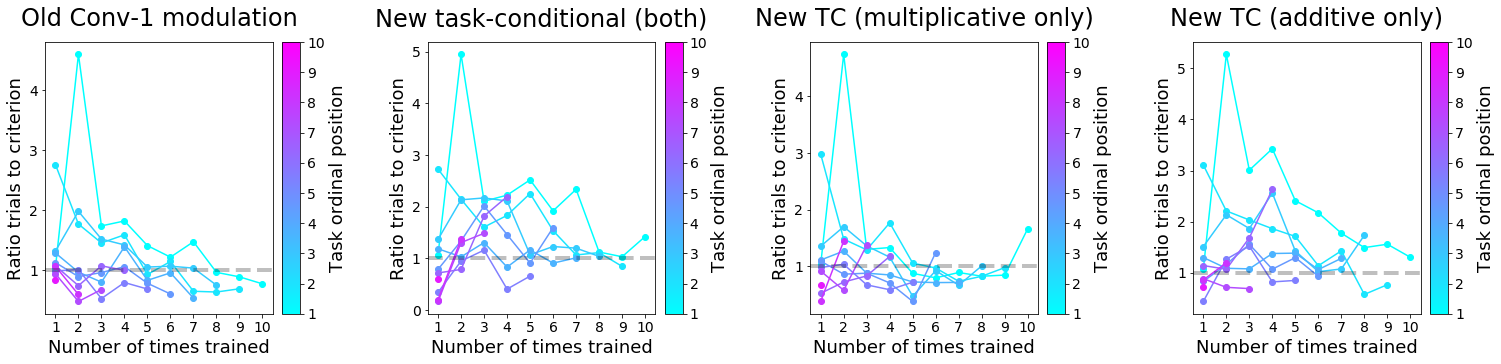

In [41]:
NROWS = 1
NCOLS = 5
COL_WIDTH = 6
ROW_HEIGHT = 5
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.5)


comparison_axes = (plt.subplot(NROWS, NCOLS, 1), None)
mod_level = 1
plots.combined_comparison_plots(six_replications_updated_analyses, query_mod_updated_analyses, '',
                                comparison_func=np.divide,
                                font_dict=multi_plot_font_dict, baseline_first=True, 
                                data_index=0, # ylim=EXAMPLE_RATIO_YLIM, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=title_font_dict,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='Ratio trials to criterion',
                                external_axes=comparison_axes, 
                                replication_levels=(mod_level,), custom_titles=(f'Old Conv-{mod_level} modulation',))



for i, (data, name) in enumerate(
    zip( (task_conditional_analyses, task_conditional_multiplicative_only_analyses, task_conditional_additive_only_analyses),
        ('New task-conditional (both)', 'New TC (multiplicative only)', 'New TC (additive only)'))):
    ax_index = 2 + i
    axes = (plt.subplot(NROWS, NCOLS, ax_index), None)
    plots.combined_comparison_plots(six_replications_updated_analyses, {1: data}, '',
                                comparison_func=np.divide,
                                font_dict=multi_plot_font_dict, baseline_first=True, 
                                data_index=0, # ylim=EXAMPLE_RATIO_YLIM, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=title_font_dict,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='Ratio trials to criterion',
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(name,))


# TEXT_POSITIONS = [(0.045, 0.825), (0.485, 0.825)]

# subfigure_text_font_dict = FONT_DICT.copy()
# subfigure_text_font_dict['fontsize'] += 4
# subfigure_text_font_dict['color'] = '#808080'
# subfigure_text_font_dict['weight'] = 'bold'

# num_subfigures = len(TEXT_POSITIONS)
# for i in range(num_subfigures):
#     pos = TEXT_POSITIONS[i]
#     plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
#              subfigure_text_font_dict, transform=figure.transFigure)

# # add markings for which plot is which
# cmap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)
# current_font_dict = FONT_DICT.copy()
# current_font_dict['fontsize'] -= 4
# current_font_dict['color'] = matplotlib.colors.to_hex(cmap(0 / 10))
# plt.text(0.615, 0.780, f'1', current_font_dict, transform=figure.transFigure)
# current_font_dict['color'] = matplotlib.colors.to_hex(cmap(1 / 10))
# plt.text(0.5725, 0.825, f'2', current_font_dict, transform=figure.transFigure)

plt.show()

# Division direct comparison

Plotting the ratio between the old task-modulated model at Conv 1 and the new task-condtional model, $ \frac{\text{old task modulated}}{TC} $, so above the $y = 1$ line means the old model is slower.

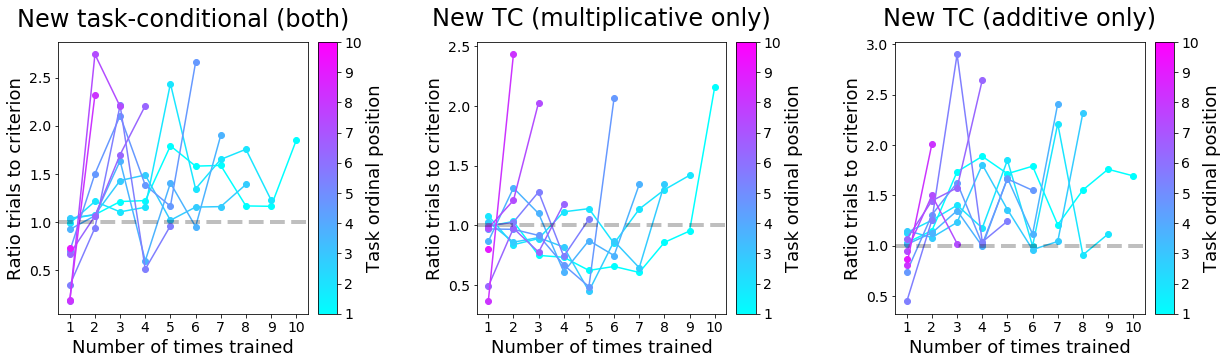

In [42]:
NROWS = 1
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.5)


mod_level = 1

for i, (data, name) in enumerate(
    zip( (task_conditional_analyses, task_conditional_multiplicative_only_analyses, task_conditional_additive_only_analyses),
        ('New task-conditional (both)', 'New TC (multiplicative only)', 'New TC (additive only)'))):
    ax_index = 1 + i
    axes = (plt.subplot(NROWS, NCOLS, ax_index), None)
    plots.combined_comparison_plots(query_mod_updated_analyses[mod_level], {1: data}, '',
                                comparison_func=np.divide,
                                font_dict=multi_plot_font_dict, baseline_first=True, 
                                data_index=0, # ylim=EXAMPLE_RATIO_YLIM, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=title_font_dict,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='Ratio trials to criterion',
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(name,))

    
# TEXT_POSITIONS = [(0.045, 0.825), (0.485, 0.825)]

# subfigure_text_font_dict = FONT_DICT.copy()
# subfigure_text_font_dict['fontsize'] += 4
# subfigure_text_font_dict['color'] = '#808080'
# subfigure_text_font_dict['weight'] = 'bold'

# num_subfigures = len(TEXT_POSITIONS)
# for i in range(num_subfigures):
#     pos = TEXT_POSITIONS[i]
#     plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
#              subfigure_text_font_dict, transform=figure.transFigure)

# # add markings for which plot is which
# cmap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)
# current_font_dict = FONT_DICT.copy()
# current_font_dict['fontsize'] -= 4
# current_font_dict['color'] = matplotlib.colors.to_hex(cmap(0 / 10))
# plt.text(0.615, 0.780, f'1', current_font_dict, transform=figure.transFigure)
# current_font_dict['color'] = matplotlib.colors.to_hex(cmap(1 / 10))
# plt.text(0.5725, 0.825, f'2', current_font_dict, transform=figure.transFigure)

plt.show()